In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import lin_data, plot_scatter
import matplotlib.pyplot as plt
import numpy as np

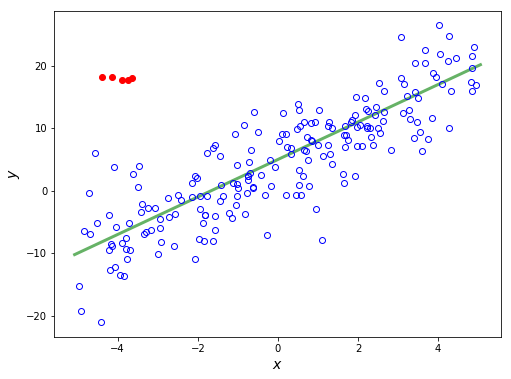

In [3]:
X, y, _, f_truth, outliers = lin_data(200, has_outlier=True)
plt.figure(figsize=(8, 6))
plot_scatter(X, y, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plt.show()

In [4]:
X_ol = np.r_[X, outliers[:, 0].reshape(-1, 1)]
y_ol = np.r_[y, outliers[:, 1]]

## 支持向量机

In [5]:
from pylib.utils.functions_for_regression import plot_fitted_line
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
svm = LinearSVR(random_state=42)
svm.fit(X, y)

LinearSVR(random_state=42)

In [7]:
y_pred = svm.predict(X)
mse = mean_squared_error(y, y_pred)
print("样本误差：{:.3f}".format(mse))

样本误差：22.811


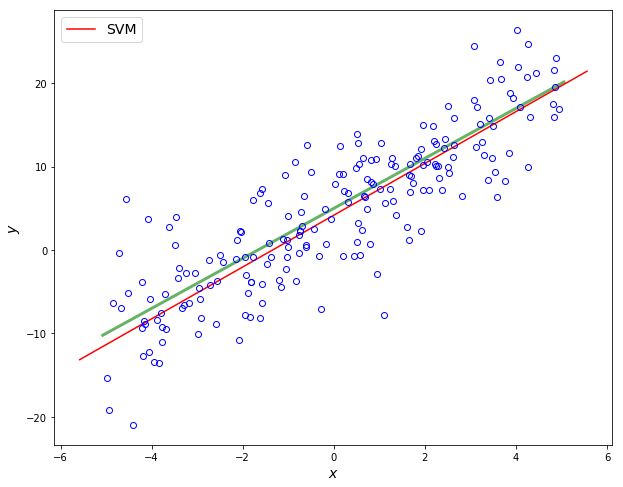

In [8]:
plt.figure(figsize=(10, 8))
plot_scatter(X, y, f=f_truth)
plot_fitted_line(svm, "SVM", "r")
plt.show()

### 不同的边缘/Epsilon不敏感

In [9]:
def find_support_vectors(svm, X, y):
    y_pred = svm.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm.epsilon)
    svm.support_ = np.argwhere(off_margin).ravel()
    X_support = X[svm.support_]
    y_support = y[svm.support_]
    return X_support, y_support

In [10]:
# 当epsilon=2.0时
svm_margin1 = LinearSVR(epsilon=2.0, random_state=42)
svm_margin1.fit(X, y) 

LinearSVR(epsilon=2.0, random_state=42)

In [11]:
X_support1, y_support1 = find_support_vectors(svm_margin1, X, y)
print("支持向量所占比例：{:.2f}%".format(len(X_support1) / len(X) * 100))

支持向量所占比例：65.50%


In [12]:
# 当epsilon=5.0时
svm_margin2 = LinearSVR(epsilon=5.0, random_state=42)
svm_margin2.fit(X, y) 

LinearSVR(epsilon=5.0, random_state=42)

In [13]:
X_support2, y_support2 = find_support_vectors(svm_margin2, X, y)
print("支持向量所占比例：{:.2f}%".format(len(X_support2) / len(X) * 100))

支持向量所占比例：28.00%


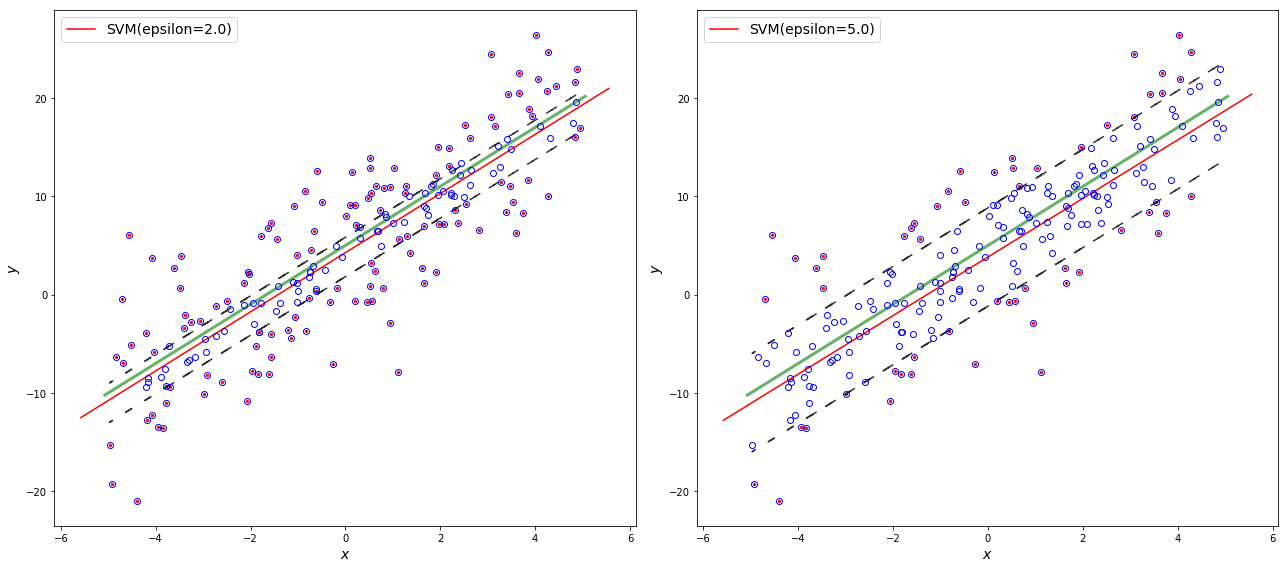

In [14]:
y_pred1 = svm_margin1.predict(X)
y_pred2 = svm_margin2.predict(X)

plt.figure(figsize=(18, 8))
plt.subplot(121)
plot_scatter(X, y, f=f_truth)
plot_fitted_line(svm_margin1, "SVM(epsilon=2.0)", "r")
plt.plot(X, y_pred2 + svm_margin1.epsilon,
         c="k", linestyle=(0, (5, 10)), alpha=0.8)
plt.plot(X, y_pred2 - svm_margin1.epsilon, 
         c="k", linestyle=(0, (5, 10)), alpha=0.8)
plt.scatter(X_support1, y_support1, c='r', s=5)
plt.legend(fontsize=14)

plt.subplot(122)
plt.plot(X, y_pred2 + svm_margin2.epsilon, 
         c="k", linestyle=(0, (5, 10)), alpha=0.8)
plt.plot(X, y_pred2 - svm_margin2.epsilon, 
         c="k", linestyle=(0, (5, 10)), alpha=0.8)
plot_scatter(X, y, f=f_truth)
plot_fitted_line(svm_margin2, "SVM(epsilon=5.0)", "r")
plt.scatter(X_support2, y_support2, c='r', s=5)
plt.tight_layout()
plt.show()

### 对异常值表现鲁棒

In [15]:
# 拟合无异常点
svm1 = LinearSVR(random_state=42)
svm1.fit(X_ol, y_ol)

LinearSVR(random_state=42)

In [16]:
y_pred = svm1.predict(X)
mse = mean_squared_error(y, y_pred)
print("样本误差：{:.3f}".format(mse))

样本误差：22.719


In [17]:
# 拟合有异常点
svm2 = LinearSVR(random_state=42)
svm2.fit(X, y)

LinearSVR(random_state=42)

In [18]:
y_pred = svm2.predict(X)
mse = mean_squared_error(y, y_pred)
print("样本误差：{:.3f}".format(mse))

样本误差：22.811


#### 对比线性回归

In [19]:
lr = LinearRegression()
lr.fit(X_ol, y_ol)

LinearRegression()

In [20]:
y_pred = lr.predict(X)
mse = mean_squared_error(y, y_pred)
print("样本误差：{:.3f}".format(mse))

样本误差：23.792


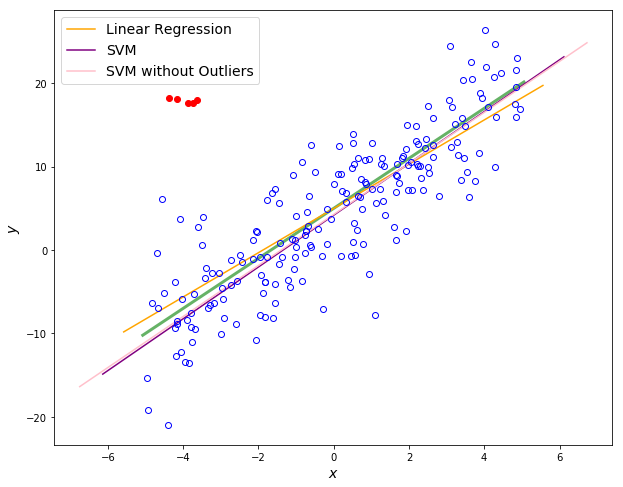

In [21]:
plt.figure(figsize=(10, 8))
plot_scatter(X, y, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plot_fitted_line(lr, "Linear Regression", "orange")
plot_fitted_line(svm2, "SVM", "purple")
plot_fitted_line(svm1, "SVM without Outliers", 'pink')
plt.show()

### 比较`LinearSVC`、`SVC`和`SGDClassifier`三种实现

In [22]:
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

In [23]:
svm_lin = LinearSVR(random_state=42)
svm_lin.fit(X_ol, y_ol)
formula1 = "Linear SVC: y={:.3f}x+{:.3f}".format(svm_lin.coef_[0], svm_lin.intercept_[0])

In [24]:
svm_svc = SVR(kernel='linear')
svm_svc.fit(X_ol, y_ol)
formula2 = "SVC: y={:.3f}x+{:.3f}".format(svm_svc.coef_[0][0], svm_svc.intercept_[0])

In [25]:
svm_sgd = SGDRegressor(loss='epsilon_insensitive', learning_rate="constant", eta0=0.001, alpha=1/len(X),
                        max_iter=1000, tol=1e-3, random_state=42)
svm_sgd.fit(X_ol, y_ol)
formula3 = "SGDClassifier: y={:.3f}x+{:.3f}".format(svm_sgd.coef_[0], svm_sgd.intercept_[0])

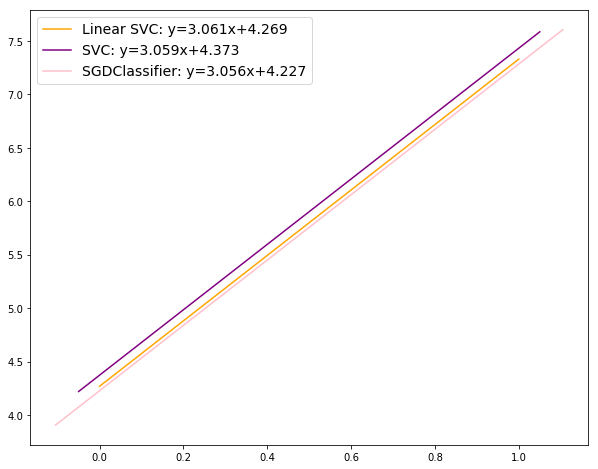

In [26]:
plt.figure(figsize=(10, 8))
# plot_scatter(X, y, f=f_truth)
# plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plot_fitted_line(svm_lin, formula1, "orange")
plot_fitted_line(svm_svc, formula2, "purple")
plot_fitted_line(svm_sgd, formula3, 'pink')
plt.show()